# Added mass - N bodies

In [282]:
using ViscousFlow

In [283]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [284]:
using LinearAlgebra

### First, some generalities

In [285]:
𝐞₁ = [1.0;0.0];
𝐞₂ = [0.0;1.0];
𝐞 = [𝐞₁,𝐞₂];

In [286]:
"""
integrate(f::Function,xmin::Real,xmax::Real,N::Int,name::String) -> Real
Integrate the function `f` between the limits `xmin` to `xmax` with `N` intervals using either the `"trapezoidal"` or `"simpson"` rule specified in `name`. The solution is returned as a Real value.
"""
function surface_integrate(body::Body{N},integrand::Array{Float64,1}) where {N}
    func = Array{Float64,1}(undef, N+1)
    func[1:end-1] .= integrand
    func[end] = integrand[1]
    s = sum(Bodies.dlength(body).*(func[1:end-1] + func[2:end]))
    return s
end

surface_integrate

#### Create the circular shapes, with discrete points and associated regularization and interpolation operator

In [287]:
n = 100
N = 2

NX = Int(ceil(sqrt(N)))
NY = Int(ceil(N/NX))
dX = 10

R = 0.5

bodies = Array{Body,1}(undef, N)

index = 0
for j in 1:NY
    for i in 1:NX
        index = index + 1
        if index > N
            break
        end
        body = Ellipse(R,R,n)
        xc = 1.0 + dX*(i-1)
        yc = 1.0 + dX*(j-1)
        T = RigidTransform((xc,yc),0.0)
        T(body)
        bodies[(j-1)*NX+i] = body
    end
end

# Find the minimum arc length
ds = minimum(Bodies.dlength(bodies[1]))

# Area of the circles
𝒱 = π*R^2

0.7853981633974483

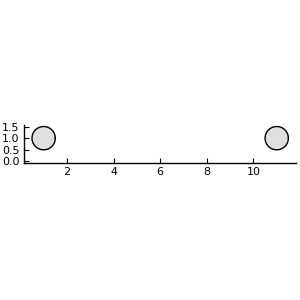

In [288]:
p = plot(size=[300,300])
for i in 1:length(bodies)
    plot!(bodies[i],fillcolor=:gray,fillrange=0,fillalpha=0.25,linecolor=:black);
end
p

In [289]:
sum(bodies[1].x)/n

1.0

#### Set up the coordinates and other useful vectors

In [290]:
bodies_x = vcat((p->p.x).(bodies)...)
bodies_y = vcat((p->p.y).(bodies)...)
X = VectorData(bodies_x,bodies_y)
f = ScalarData(X);

#### Create a grid and a Laplacian operator on it

In [291]:
nx = 500;
Lx = 2.0 + dX*(NX-1);
display(Lx)
Ly = 2.0 + dX*(NY-1);
dx = Lx/(nx-2);
ny = Int(ceil(Ly/dx))+2
display(ny)
w = Nodes(Dual,(nx,ny));

12.0

85

In [292]:
L = plan_laplacian(size(w),with_inverse=true)

Discrete Laplacian (and inverse) on a (nx = 500, ny = 85) grid with spacing 1.0

In [293]:
println("Ratio of arc spacing to cell size = ",ds/dx)

Ratio of arc spacing to cell size = 1.3035465017423087


In [294]:
E = Regularize(X,dx;issymmetric=true)
Hmat,Emat = RegularizationMatrix(E,f,w);

#### And now create the saddle-point system

In [295]:
L⁻¹(w::T) where {T} = L\w
PS = SaddleSystem((w,f),(L⁻¹,Hmat,Emat),issymmetric=true,isposdef=true)

Saddle system with 200 constraints and
   State of type Nodes{Dual,500,85}
   Force of type ScalarData{200}


#### Create some data structures for general use

In [296]:
ψb = ScalarData(X)
w = Nodes(Dual,(nx,ny))
ψ = Nodes(Dual,w);

The added mass matrix for two degrees of freedom is (2xN)-by-(2xN)

In [300]:
M = zeros(2*N,2*N)

4×4 Array{Float64,2}:
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

### Solve flow generated by a translating cylinder

In [302]:
U = zeros(N,1);
V = zeros(N,1);

for k in 2:2
    for j in 1:2 # dimension
    
        U .= 0.0;
        V .= 0.0;
        if j == 1
            U[k] = 1.0;
        else
            V[k] = 1.0;
        end

        for i in 1:N
            ψb[((i-1)*n+1):((i-1)*n+n)] = U[i]*(bodies[i].y .- bodies[i].cent[2]) - V[i]*(bodies[i].x .- bodies[i].cent[1])
        end

        ψ,f = PS\(w,ψb);

        for i in 2:2
            integrand_x = (f[(i-1)*n+1:(i-1)*n+n]./Bodies.dlength(bodies[i])).*(bodies[i].y);
            integrand_y = -(f[(i-1)*n+1:(i-1)*n+n]./Bodies.dlength(bodies[i])).*(bodies[i].x);
            Pʲ = -𝒱*𝐞[j] + 0.5*[surface_integrate(bodies[i],integrand_x);surface_integrate(bodies[i],integrand_y)]
            M[(i-1)*2+1,(k-1)*2+j] = dot(Pʲ,𝐞[1])
            M[(i-1)*2+2,(k-1)*2+j] = dot(Pʲ,𝐞[2])
        end
    end
end

$\begin{bmatrix}
f_{1x}\\
f_{1y}\\
f_{2x}\\
f_{2y}
\end{bmatrix}$ =
-$\begin{bmatrix}
M_{11xx} & M_{11yx} & M_{12xx} & M_{12yx} \\
M_{11xy} & M_{11yy} & M_{12xy} & M_{12yy} \\
M_{21xx} & M_{21yx} & M_{22xx} & M_{22yx} \\
M_{21xy} & M_{21yy} & M_{22xy} & M_{22yy}
\end{bmatrix}$
$\begin{bmatrix}
a_{1x}\\
a_{1y}\\
a_{2x}\\
a_{2y}
\end{bmatrix}$

In [303]:
M

4×4 Array{Float64,2}:
 0.835622     -0.0361953  0.0          0.0      
 1.26461e-15   0.872294   0.0          0.0      
 0.0           0.0        0.835622     0.0361953
 0.0           0.0        9.80119e-15  0.43795  

#### Plot the result

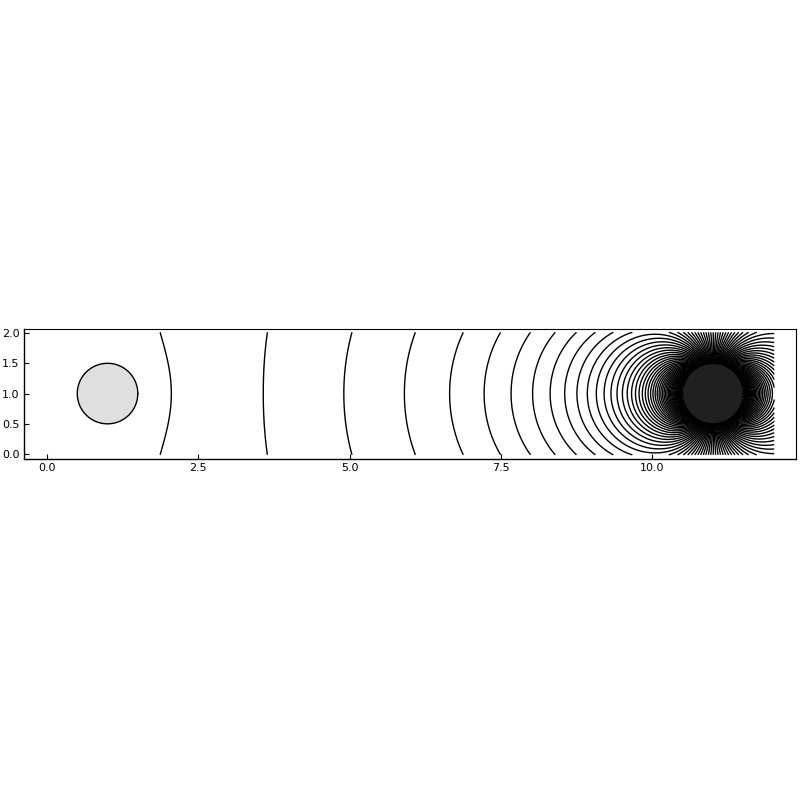

In [248]:
xg,yg = coordinates(ψ,dx=dx)
p = plot(xg,yg,ψ,linecolor=:black,levels=range(-1,1,length=200),size=[800,800])
for i in 1:length(bodies)
    plot!(bodies[i],fillcolor=:gray,fillrange=0,fillalpha=0.25,linecolor=:black);
end
p

In [307]:
sum(f[n+1:2n])

0.03619533876969125